# Projekt zaliczeniowy

**Natalia Wilczek 
Maja Dulniak**

*Politechnika Lubelska*

**O zbiorze**

Dane pochodzą ze strony : https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species?datasetId=456014

Zestaw danych walidacyjnych dla 100 gatunków motyli lub ciem. Wszystkie obrazy są 224 X 224 X 3 w formacie jpg.

Zestaw train składa się z 12594 obrazów podzielonych na 100 podkatalogów, po jednym dla każdego gatunku.

Zestaw test składa się z 500 obrazów podzielonych na 100 podkatalogów z 5 obrazami testowymi na gatunek.

Prawidłowy zestaw składa się z 500 obrazów podzielonych na 100 podkatalogów z 5 obrazami do walidacji na gatunek.

Dołączone są pliki CSV. Plik motyle i ćmy .csv składa się z 4 kolumn z 13595 wierszami. Pierwszy wiersz to nagłówek, pozostałe wiersze dotyczą każdego pliku obrazu w zestawie danych pociągu, testu i walidacji,

Kolumny to identyfikator klasy, ścieżki do plików, etykiety i zestaw danych. Kolumna filepaths zawiera ścieżkę względną do obrazu.

Kolumna etykiet zawiera tekstową etykietę gatunków powiązaną z plikiem obrazu. Kolumna zestawu danych określa, które zestaw danych (train, test lub valid), do którego należy powiązany obraz. Kolumna identyfikatora klasy zawiera numeryczny indeks klasy dla pliku obrazu.

In [1]:
library(keras)
suppressMessages(library(tidyverse))
library(tensorflow)
library(tidyverse)

# Wczytanie danych 

In [2]:
butterfly<-'/kaggle/input/butterfly-images40-species/butterflies and moths.csv'

train_dir <- "/kaggle/input/butterfly-images40-species/train"
test_dir <- "/kaggle/input/butterfly-images40-species/test"
val_dir <- "/kaggle/input/butterfly-images40-species/valid"

# Przygotowanie danych do uczenia

In [3]:
train_datagen <- image_data_generator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = TRUE)

test_datagen <- image_data_generator(rescale = 1./255,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = TRUE)

val_datagen <- image_data_generator(rescale = 1/255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = TRUE)

In [4]:
# Tworzenie generatorów danych obrazowych
train_generator <- flow_images_from_directory(
  train_dir,
  generator = train_datagen,
  target_size = c(256, 256),
  batch_size = 32,
  class_mode = "categorical"
)

test_generator <- flow_images_from_directory(
  test_dir,
  generato = test_datagen,
  target_size = c(256, 256),
  batch_size = 32,
  class_mode = "categorical"
)

val_generator <- flow_images_from_directory(
  val_dir,
  generato = val_datagen,
  target_size = c(256, 256),
  batch_size = 32,
  class_mode = "categorical"
)

In [5]:
x = generator_next(test_generator)
str(x)

List of 2
 $ : num [1:32, 1:256, 1:256, 1:3] 0.255 0 0.176 0.744 0.187 ...
 $ : num [1:32, 1:100] 0 0 0 0 0 0 0 0 0 0 ...


# Wyświelenie przykładowych obrazków

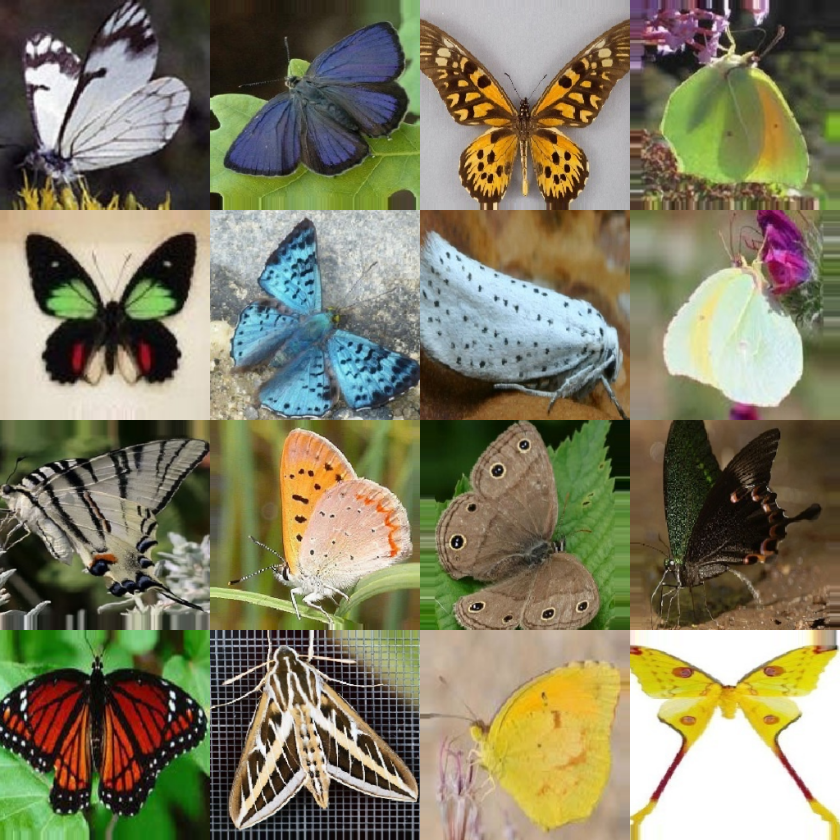

In [6]:
par(mfrow = c(4, 4), mar = c(0, 0, 0, 0))
for (i in 1:16) {
  img <- train_generator[[1]][[1]][i, , , ]
 plot(as.raster(img))}

# Model VGG16

**Sieć VGG16**, zwana również siecią OxfordNet, to model konwolucyjnej sieci neuronowej opracowany przez Visual Geometry Group (VGG) z Uniwersytetu w Oksfordzie. Model ten jest jednym z najbardziej znanych i szeroko stosowanych modeli w dziedzinie uczenia maszynowego, szczególnie w kontekście problemów związanych z przetwarzaniem obrazów i wizją komputerową.

**Model VGG16** składa się z 16 warstw, które przekształcają dane wejściowe (obrazy) na wynikową klasyfikację. Te warstwy obejmują 13 warstw konwolucyjnych, z których każda używa filtrów 3x3, 2 warstwy gęsto połączonych (fully-connected) oraz warstwę wyjściową Softmax do klasyfikacji.

**Sieć VGG16** jest znana z tego, że jest relatywnie prostym, ale mocnym modelem, który osiąga bardzo dobre wyniki na wielu zestawach danych obrazów. Choć istnieją bardziej zaawansowane architektury, takie jak ResNet, DenseNet czy EfficientNet, które osiągają lepsze wyniki, VGG16 nadal jest często używany jako punkt odniesienia ze względu na jego prostotę i skuteczność. Ponadto, sieci VGG są często używane jako podstawy do transfer learningu, gdzie wstępnie wytrenowany model VGG jest dostosowywany do nowego zadania.

In [7]:
base = application_vgg16(include_top = FALSE, input_shape = c(256,256,3))
summary(base)

Model: "vgg16"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_1 (InputLayer)               [(None, 256, 256, 3)]           0           
                                                                                
 block1_conv1 (Conv2D)              (None, 256, 256, 64)            1792        
                                                                                
 block1_conv2 (Conv2D)              (None, 256, 256, 64)            36928       
                                                                                
 block1_pool (MaxPooling2D)         (None, 128, 128, 64)            0           
                                                                                
 block2_conv1 (Conv2D)              (None, 128, 128, 128)           73856       
                                                                                
 block2_conv2

In [8]:
model1 <- keras_model_sequential() %>% 
  layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = "relu",
                input_shape = c(256,256,3)) %>% 
                  layer_max_pooling_2d(pool_size = c(2,2)) %>% 
                  layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = "relu") %>% 
                  layer_max_pooling_2d(pool_size = c(2,2)) %>% 
                  layer_flatten() %>% 
                  layer_dense(units = 512, activation = "relu") %>% 
                  layer_dense(units = 100, activation = "softmax")

Kompilacja modelu 

In [9]:
model1 %>% compile(
  optimizer = "adam",
  loss = 'categorical_crossentropy',
  metrics = c("accuracy"))

`geom_smooth()` using formula = 'y ~ x'


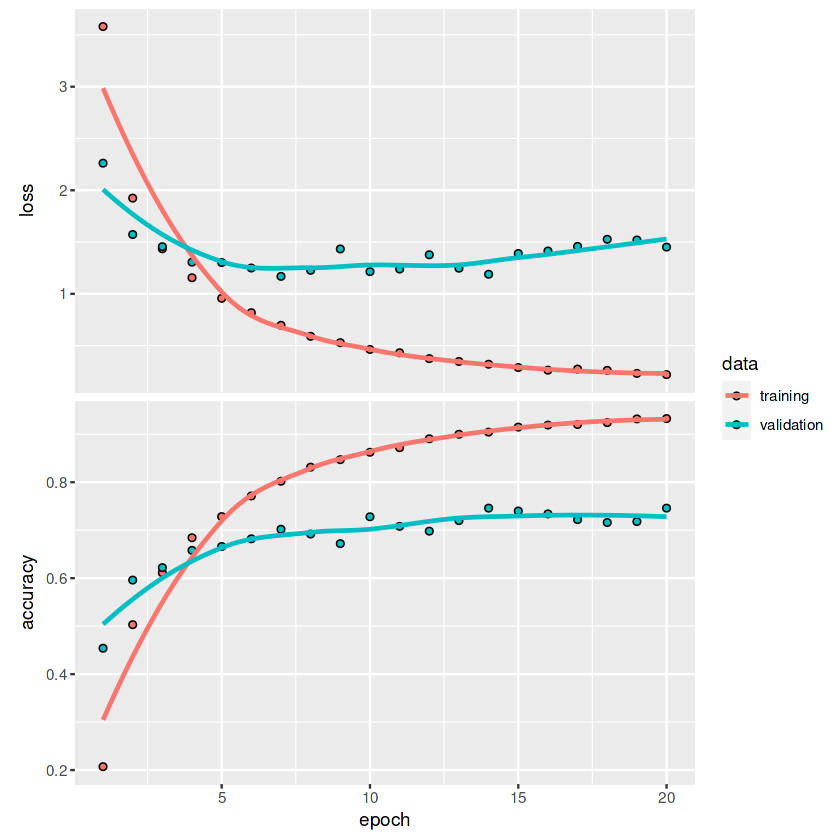

In [10]:
historia <- model1 %>% fit(
  train_generator,
  epochs = 20,
  validation_data = val_generator)
plot(historia)

In [11]:
model1 %>% evaluate(test_generator)

loss accuracy 
1.253891 0.772000

**Wnioski **

Dokładność treningowa wynosi *92%*, co oznacza, że model poprawnie klasyfikuje 92% obserwacji na zestawie treningowym. 

Strata na zestawie treningowym *0.2* jest stosunkowo niska, co sugeruje, że model dobrze radzi sobie z przewidywaniem etykiet na zestawie treningowym.

Strata walidacyjna jest znacznie wyższa niż na zestawie treningowym. To sugeruje, że model może mieć problemy z generalizacją na nowe dane, których nie widział podczas treningu. Może to być sygnał przetrenowania.

Dokładność walidacyjna *70%* oznacza, że model poprawnie klasyfikuje 70% obserwacji na zestawie walidacyjnym. Ponieważ jest to wartość niższa niż dokładność treningowa, może to także sugerować, że model ma problemy z generalizacją.

Podsumowując, model pierwszy wydaje się być dość skuteczny na zestawie treningowym, ale ma trudności ze skutecznym przewidywaniem na zestawie walidacyjnym.

# Model InceptionResNetV2

**InceptionResNetV2** to model konwolucyjnej sieci neuronowej (Convolutional Neural Network, CNN) opracowany przez Google Brain Team. Jest to kombinacja dwóch ważnych koncepcji w dziedzinie głębokiego uczenia - "Inception" pochodzącej z modelu GoogleNet i "ResNet" (Residual Network) od Microsoftu.

"Inception" to architektura, która zamiast stosować filtry o stałym rozmiarze w warstwach konwolucyjnych, korzysta z wielu różnych rozmiarów filtrów równolegle i następnie łączy ich wyniki. Pozwala to na wykrywanie cech na różnych skalach.

Z drugiej strony, "ResNet" wprowadza koncepcję "połączeń skrótowych" (shortcut connections lub residual connections), które pozwalają na przepływ gradientów bezpośrednio przez kilka warstw, co pomaga rozwiązać problem "zanikającego gradientu" (vanishing gradient) podczas trenowania bardzo głębokich sieci.

InceptionResNetV2 łączy te dwie koncepcje, korzystając z modułów Inception z dodatkowymi połączeniami skrótowymi. Sieć składa się z wielu takich modułów ułożonych jeden po drugim.

In [12]:
base = application_inception_resnet_v2(include_top = FALSE, input_shape = c(256, 256, 3))
freeze_weights(base)
unfreeze_weights(base, from = "conv2d_172")

In [13]:
summary(base)

Model: "inception_resnet_v2"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_2 (InputLayer)     [(None, 256, 256  0        []                         
                          , 3)]                                                 
                                                                                
 conv2d_2 (Conv2D)        (None, 127, 127,  864      ['input_2[0][0]']          
                           32)                                                  
                                                                                
 batch_normalization (Bat  (None, 127, 127,  96      ['conv2d_2[0][0]']         
 chNormalization)          32)                                                  
                                                                                
 activation (Activation)  (None, 127, 127,  0        ['batch_normalization[0][0]

In [14]:
model2 = keras_model_sequential() %>%
  base %>%
  layer_global_average_pooling_2d() %>% 
  layer_dense(units = 512, activation = 'relu') %>%
  layer_dense(units = 100, activation = 'softmax')


In [15]:
summary(model2)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 inception_resnet_v2 (Functional)   (None, 6, 6, 1536)              54336736    
                                                                                
 global_average_pooling2d (GlobalAv  (None, 1536)                   0           
 eragePooling2D)                                                                
                                                                                
 dense_3 (Dense)                    (None, 512)                     786944      
                                                                                
 dense_2 (Dense)                    (None, 100)                     51300       
                                                                                
Total params: 55,174,980
Trainable params: 21,417,540
Non-trainable params: 33,757,440


In [16]:
optimaz = tf$keras$optimizers$Adam(learning_rate = 0.0005)

Kompilacja modelu

In [17]:
model2 %>% compile(
  optimizer = optimaz,
  loss = 'categorical_crossentropy',
  metrics = c("accuracy"))

`geom_smooth()` using formula = 'y ~ x'


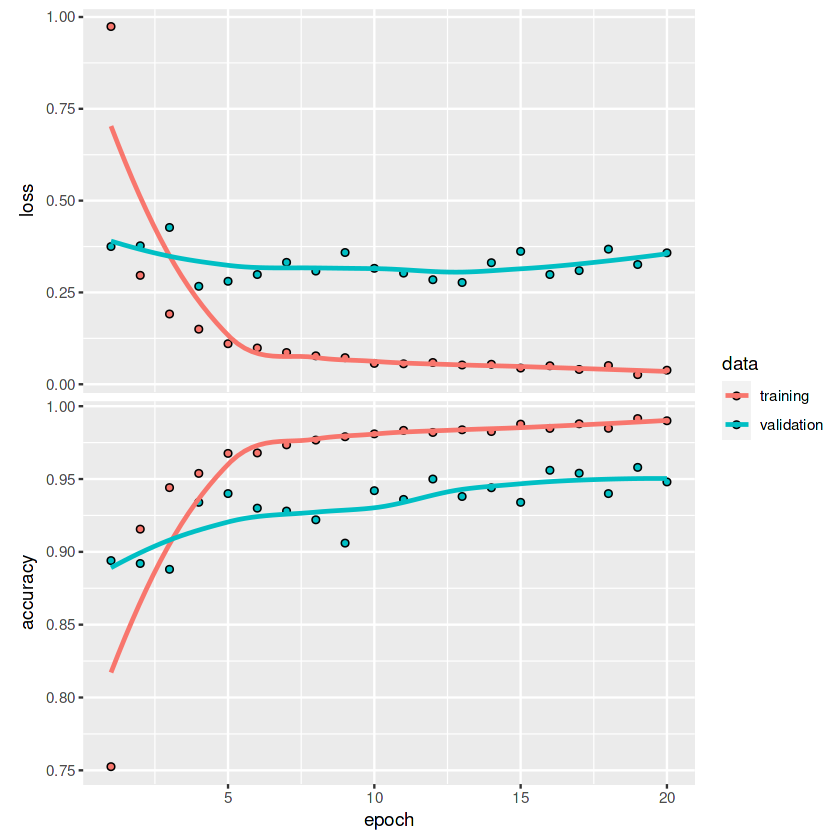

In [18]:
historia2 <- model2 %>% 
fit(
  train_generator,
  epochs = 20,
  validation_data = val_generator)
plot(historia2)

In [19]:
model2 %>% evaluate(test_generator)

loss  accuracy 
0.2222683 0.9560000

**Wnioski **

Model wydaje się radzić sobie całkiem dobrze, z dokładnością prawie *96%*, ale ma pewną stratę, co wskazuje, że nie przewiduje idealnie każdej próbki.

# Model MobileNet

**MobileNet** to klasa wydajnych modeli opracowanych przez Google dla urządzeń mobilnych i na brzegu sieci (edge devices). Jest zaprojektowany tak, aby zapewnić wysoką wydajność dla mobilnych i wbudowanych aplikacji wizyjnych, co wymaga od modelu małych rozmiarów, szybkiego wnioskowania, jednocześnie zachowując dobry poziom dokładności.

MobileNet używa konwolucji separowalnych w głąb jako swojego podstawowego modułu, zamiast regularnych konwolucji, które są używane w innych modelach, takich jak VGG czy ResNet. Konwolucja separowalna w głąb to rodzaj operacji konwolucji, która składa się z dwóch warstw - konwolucji w głąb i konwolucji punktowej. Konwolucja w głąb stosuje pojedynczy filtr do każdego kanału wejściowego, a następnie konwolucja punktowa stosuje konwolucję 1x1, aby połączyć wyniki warstwy w głąb.

Zastępując standardowe konwolucje konwolucjami separowalnymi w głąb, MobileNet znacznie redukuje rozmiar modelu i obciążenie obliczeniowe. Dzięki temu nadaje się do wdrożenia w urządzeniach mobilnych i innych środowiskach o ograniczonych zasobach obliczeniowych.

In [20]:
mobile_baza = application_mobilenet_v2(input_shape = c(256, 256, 3), include_top = FALSE)
summary(mobile_baza)
freeze_weights(mobile_baza)
unfreeze_weights(mobile_baza, from = " block_2_project")

Model: "mobilenetv2_1.00_224"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_3 (InputLayer)     [(None, 256, 256  0        []                         
                          , 3)]                                                 
                                                                                
 Conv1 (Conv2D)           (None, 128, 128,  864      ['input_3[0][0]']          
                           32)                                                  
                                                                                
 bn_Conv1 (BatchNormaliza  (None, 128, 128,  128     ['Conv1[0][0]']            
 tion)                     32)                                                  
                                                                                
 Conv1_relu (ReLU)        (None, 128, 128,  0        ['bn_Conv1[0][0]']        

In [21]:
model3 = keras_model_sequential() %>%
  mobile_baza %>%
  layer_global_average_pooling_2d() %>% 
  layer_dense(units = 512, activation = 'relu') %>%
  layer_dense(units = 100, activation = 'softmax')

In [22]:
summary(model3)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 mobilenetv2_1.00_224 (Functional)  (None, 8, 8, 1280)              2257984     
                                                                                
 global_average_pooling2d_1 (Global  (None, 1280)                   0           
 AveragePooling2D)                                                              
                                                                                
 dense_5 (Dense)                    (None, 512)                     655872      
                                                                                
 dense_4 (Dense)                    (None, 100)                     51300       
                                                                                
Total params: 2,965,156
Trainable params: 707,172
Non-trainable params: 2,257,984
_____

In [23]:
optimaz = tf$keras$optimizers$Adam(learning_rate = 0.001)

In [24]:
model3 %>% compile(optimizer = optimaz,
                 loss = "categorical_crossentropy",
                 metrics = "accuracy")

In [25]:
callbacks = list(callback_early_stopping(patience = 5, monitor = "val_accuracy", restore_best_weights = TRUE))

In [26]:
historia3 = fit(model3, train_generator, epochs = 20, validation_data = val_generator, callbacks=callbacks)

`geom_smooth()` using formula = 'y ~ x'


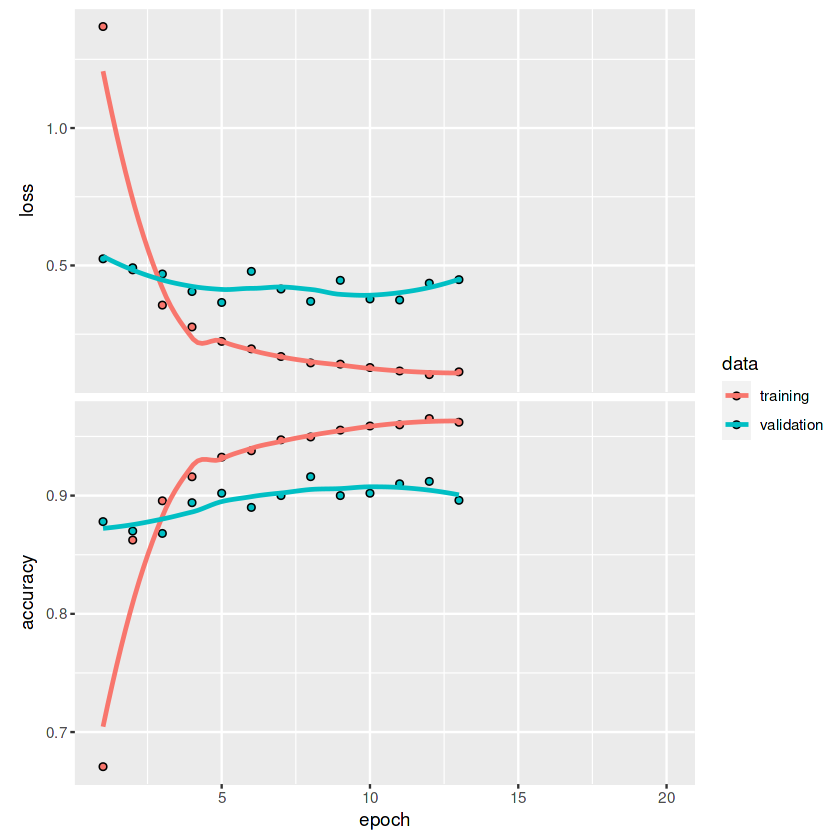

In [27]:
plot(historia3)

In [28]:
model3 %>% evaluate(test_generator)

loss accuracy 
0.340263 0.898000

**Wnioski **

Trzeci model wykazuje dobre wyniki na zestawie treningowym i stosunkowo dobre wyniki na zestawie walidacyjnym. Może to sugerować, że model jest dobrze dopasowany do danych treningowych i jest w stanie generalizować na nowe dane, chociaż możliwe, że mógłby uzyskać lepszą wydajność na zestawie walidacyjnym